# Parton showers

Written by:

- Tony Menzo (School of Physics, University of Cincinnati)

Built upon:
- S. Hoeche's parton shower tutorial [GitLab: shoeche/tutorials/ps](https://gitlab.com/shoeche/tutorials/-/tree/master/ps?ref_type=heads)

In this tutorial we will build a simplified parton shower.

Colliders probe energy scales where quarks and gluons interact perturbatively. At leading order, hard scattering processes produce a few high-energy colored partons. However, these partons are not observed directly in the detector. Instead, they radiate additional quarks and gluons as they evolve toward lower virtualities, forming collimated sprays of particles known as jets. This cascade of emissions is governed by the infrared structure of QCD and is captured by a procedure called ***parton showering***. The parton shower resums the dominant soft and collinear logarithms to all orders, providing a probabilistic picture of how a few energetic partons evolve into a complex multibody final state. In Monte Carlo event generators, parton showers play a critical role in bridging the gap between the hard scattering and the nonperturbative hadronization stage. In this tutorial, we'll explore the physics behind parton showers and how they are implemented in modern event generators.

## Requirements

This notebook requires a few external dependencies which are imported here. First we set up our plotting with `matplotlib`.

In [1]:
import matplotlib.pyplot as plt

Next, we have a few local utilities for vectors, particles, $\alpha_s$ evolution, and $e^+ e^- \to f\bar{f}$ matrix element/phase space generation.

In [2]:
# Download the `vector`, `particle`, 'alphas', and 'eetojj' modules.
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.solutions/mc/vector.py
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.solutions/mc/particle.py

# Import the necessary classes.
from vector import FourVector
from particle import ParticleDatabase, ParticleData, Particle
from alphas import AlphaS, SUN
from eetojj import eeTojj

We will also need some particle data. We will use the Pythia particle data, which can be read by the `pdb` class we just imported.

In [3]:
# Download the Pythia particle database.
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.solutions/mc/data/ParticleData.xml

# Create a particle database we can use throughout this notebook.
pdb = ParticleDatabase()

Finally, we need a random number generator. We could use one of the RNGs implemented in [`rng.ipynb`](rng.ipynb), but instead we will use the default `numpy` RNG. We also need the `math` module.

In [4]:
# Import the `numpy` modules.
import numpy as np

# Create an RNG, with a seed of 10.
np.random.default_rng(10)

Generator(PCG64) at 0x72828A952EA0

### Evolution of $\alpha_s$
First let's define some utility functions that will come in handy, for example, the running of $\alpha_s(\mu)$ using the tree-level and one-loop calculations.

In [5]:
# Define QCD parameters and running constants
_NC = 3
_MZ = 91.1880 # \pm 0.0020 GeV
_ALPHASMZ = 0.1180 # \pm 0.0009
_Mb = 4.75 # GeV (pole mass)
_Mc = 1.3 # GeV (pole mass)

alphas = AlphaS(mZ = _MZ, asmZ = _ALPHASMZ, nc = _NC, mb = _Mb, mc = _Mc)

print('\\alpha_s^tree(mc) =', alphas.as0(_Mc**2))  # Example usage for mc
print('\\alpha_s^1-loop(mb) =', alphas.as1(_Mb**2))  # Example usage for mb


\alpha_s(91.188 GeV) = 0.118
\alpha_s^tree(mc) = 0.34037686303713927
\alpha_s^1-loop(mb) = 0.21475347391182134


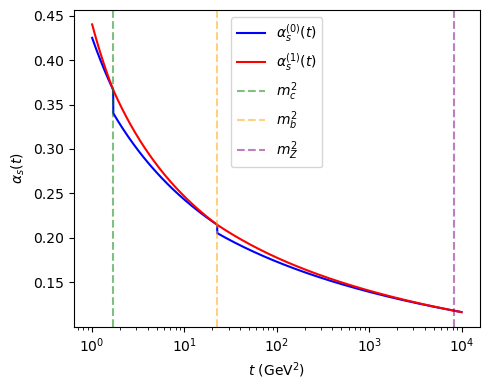

In [6]:
# Plot the running coupling
t = np.geomspace(1, 10000, 10000)
fig, ax = plt.subplots(figsize=(5, 4))

alphas_tree = np.vectorize(alphas.as0)(t)
alphas_oneloop = np.vectorize(alphas.as1)(t)

# Plot the running couplings
ax.plot(t, alphas_tree, label=r"$\alpha_s^{(0)}(t)$", color='blue')
ax.plot(t, alphas_oneloop, label=r"$\alpha_s^{(1)}(t)$", color='red')

# Plot vertical lines for mc and mb
ax.axvline(_Mc**2, color='green', linestyle='--', label=r"$m_c^2$", alpha = 0.5)
ax.axvline(_Mb**2, color='orange', linestyle='--', label=r"$m_b^2$", alpha = 0.5)
ax.axvline(_MZ**2, color='purple', linestyle='--', label=r"$m_Z^2$", alpha = 0.5)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r"$t$ (GeV$^2$)")
ax.set_ylabel(r"$\alpha_s(t)$")
ax.legend()
fig.tight_layout()

### **Particle database**

In [7]:
# Initialize particle database
pdb = ParticleDatabase(xmlfile="./data/ParticleData.xml")

print("Particle Database initialized with", len(pdb), "particles.")
# Example of accessing a particle
particle = pdb[211] # Get the pion (pi+)
print("Particle ID:", particle.pid)
print("Particle Name:", particle.name)
print("Particle Mass (GeV):", particle.mass)

# The particle can also accessed via a string
particle = pdb["pi-"]
print("Particle ID:", particle.pid)
print("Particle Name:", particle.name)
print("Particle Mass (GeV):", particle.mass)

Particle Database initialized with 2414 particles.
Particle ID: 211
Particle Name: pi+
Particle Mass (GeV): 0.13957
Particle ID: -211
Particle Name: pi-
Particle Mass (GeV): 0.13957


## QCD amplitudes and dipole factorization
Consider the process $e^+ e^- \to \gamma/Z \to (m+1)$-QCD partons, described by a tree-level matrix element $\mathcal{M}_{m+1}$. The squared matrix element $|\mathcal{M}_{m+1}|^2$ depends on the $i$-th final state momentum $p_i$ in two different phase-space regions: 
1. The **soft** region, defined by the limit $$ p_i = \lambda q, \quad \lambda \to 0 $$ with $q$ being an arbitrary four-momentum, and in which the squared matrix element behaves as $$|\mathcal{M}_{m+1}|^2 \propto \frac{1}{\lambda^2}, $$
2. The **collinear** region, defined by the limit $$ p_i \to p_j \frac{1 - z}{z} $$ where $p_j$ is the momentum of another parton in $\mathcal{M}_{m+1}$, and in which the squared matrix element behaves as $$ |\mathcal{M}_{m+1}|^2 \propto \frac{1}{p_i p_j}. $$

In both kinematic regions the squared matrix elements exhibit singularities in the IR, typically referred to as **soft and collinear divergences**. Importantly, the singular behavior in these regions is *quasi-local*, meaning that the singular terms with respect to the momentum $p_i$ in $\mathcal{M}_{m+1}$ can be thought of as insertions of parton $i$ over all possible external legs of a tree-level amplitude $\mathcal{M}_m$ with $m$-QCD partons. In other words, the singular factor only depends on the momenta and quantum numbers of three partons: the parton $i$ that is inserted into $\mathcal{M}_m$ and the partons $j$, and $k$ in $\mathcal{M}_m$. Explicitly, the squared matrix element can be factorized as
$$ 
|\mathcal{M}_{m+1}|^2 \to |\mathcal{M}_m|^2 \otimes \boldsymbol{V}_{ij,k}
$$
where $\boldsymbol{V}_{ij,k}$ is the singular factor, also known as a **splitting function**. Typically, the $i$-th and $j$-th partons are termed **emitters** and the third parton ($k$) is termed the **spectator**.

<p align="center">
  <img src="./dipole_factorization.png" />
</p>

The $\boldsymbol{V}_{ij,k}$ splitting functions serve as the basis for both:

* **Subtraction methods** in fixed-order NLO calculations, such as the Catani–Seymour dipole formalism, where $\boldsymbol{V}_{ij,k}$ is used to subtract IR divergences from real emission diagrams in a way that exactly cancels the corresponding virtual corrections, and
* **Parton shower algorithms**, where $\boldsymbol{V}_{ij,k}$ governs the probabilistic branching of partons, encoding the probability of a given soft/collinear emission in terms of a dipole formed by emitter and spectator.

### Kinematics
The momentum of the spectator and emitter is typically written in a convenient form:
$$
\tilde{p}_k^\mu = \frac{1}{1-y_{ij,k}}p_k^\mu, \quad \tilde{p}_{ij}^\mu = p^\mu_i + p^\mu_j - \frac{y_{ij,k}}{1-y_{ij,k}} p^\mu_k
$$
where 
$$
y_{ij,k} = \frac{p_i p_j}{p_i p_j + p_i p_k + p_j p_k}.
$$
Note that the emitter and spectator are on-shell ($\tilde{p}_{ij}^2 = \tilde{p}_k^2 = 0$) and that momentum conservation is explicitly encoded
$$
p^\mu_i + p_j^\mu + p_k^\mu = \tilde{p}_{ij}^\mu + \tilde{p}_k^\mu.
$$

The splitting functions also depend on a momentum sharing variable $\tilde{z}$, which characterizes how momentum is partitioned between partons $i$ and $j$:
$$
\tilde{z}_i = \frac{p_i p_k}{p_ip_k + p_j p_k} = \frac{p_i \tilde{p}_k}{\tilde{p}_{ij} \tilde{p}_k}, \quad \tilde{z}_j = \frac{p_j p_k}{p_i p_k + p_j p_k} = \frac{p_j \tilde{p}_k}{\tilde{p}_{ij} \tilde{p}_k} = 1 - \tilde{z}_i.
$$
This variable is closely related to the energy fraction in the collinear limit and appears explicitly in the spin-averaged splitting kernels.

### Explicit splitting functions
Instead of deriving the splitting function from first-principles a la QCD (a fun exercise!), we will simply use the spin-averaged splitting functions quoted in Eq. (3.22) of [arXiv:1411.4085](https://arxiv.org/pdf/1411.4085). Using these expression we can define splitting `Kernel` classes for all possible splittings: `Pqq`, `Pgg`, and `Pgq`.

In [8]:
class Kernel(SUN):
    """
    Base class for parton shower kernels.
    """
    def __init__(self, flavs, nc = 3):
        self.flavs = flavs
        super().__init__(nc)

class Pqq(Kernel):
    """
    q -> qg splitting kernel
    """
    def Value(self, z, y):
        return self.CF * (2. / (1. - z * (1. - y)) - (1. + z))

class Pgg(Kernel):
    """
    g -> gg splitting kernel
    """
    def Value(self, z, y):
        return self.CA / 2. * (2. / (1. - z * (1. - y)) - 2. + z * (1. - z))

class Pgq(Kernel):
    """
    g -> q qbar splitting kernel
    """
    def Value(self, z, y):
        return self.TR / 2. * (1. - 2. * z * (1.-z))

In [9]:
# Initialize a u-u-g splitting kernel
puu = Pqq(flavs = [1, 1, 21])
# Initialize a g-g-g splitting kernel
pgg = Pgg(flavs = [21, 21, 21])
# Initialize a g-u-ubar splitting kernel
pgu = Pgq(flavs = [21, 1, -1])

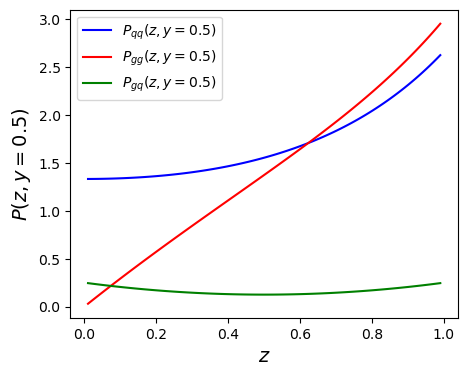

In [10]:
# Plot the different splitting kernel distributions
fig, ax = plt.subplots(figsize=(5, 4))
z = np.linspace(0.01, 0.99, 100)
ax.plot(z, puu.Value(z, 0.5), label=r"$P_{qq}(z, y=0.5)$", color='blue')
ax.plot(z, pgg.Value(z, 0.5), label=r"$P_{gg}(z, y=0.5)$", color='red')
ax.plot(z, pgu.Value(z, 0.5), label=r"$P_{gq}(z, y=0.5)$", color='green')
ax.set_xlabel(r"$z$", fontsize = 14)
ax.set_ylabel(r"$P(z, y=0.5)$", fontsize = 14)
ax.legend()

With the splitting kernels defined, we can begin to build out our showering algorithm. Generically, the `Shower` class requires two arguments as input, the strong coupling $\alpha_s$, and cutoff scale in our evolution variable $t_0$, $p_{T,0}$, etc. which tells us when to terminate the shower and hand things to the hadronization algorithm. We'll also need to initialize all possible/allowed splitting kernels, i.e. flavor assignments, using the `Kernel`'s defined above.

In [11]:
class Shower:
    def __init__(self, alpha, t0):
        """
        Final state parton shower for, e.g., e+ e- \to q qbar.
        """
        self.t0 = t0
        self.alpha = alpha
        self.alphaMax = alpha(self.t0)
        # Define the allowed flavors for each kernel
        Pqq_flavors = [ParticleDatabase[f'{flav}'].pid for flav in ['u', 'ubar', 'd', 'dbar', 's', 'sbar', 'c', 'cbar', 'b', 'bbar']]
        Pgq_flavors = [ParticleDatabase[f'{flav}'].pid for flav in ['u', 'd', 's', 'c', 'b']]
        # Initialize the kernels
        self.kernels = [Pqq([flav,flav,21]) for flav in Pqq_flavors]
        self.kernels += [Pgq([21,flav,-flav]) for flav in Pgq_flavors]
        self.kernels += [Pgg([21,21,21])]

## Reshuffling momentum (more kinematics)

To generate emissions in a parton shower, we must map a configuration with $m$ partons into one with $(m+1)$ partons in a way that respects QCD factorization properties. This mapping must:

* Preserve total momentum conservation,
* Ensure all partons are on-shell,
* Reproduce the correct singular limits.

In the discussion above, a dipole emission from partons $ij$ with spectator $k$ leads to new momenta $\tilde{p}_{ij}$ and $\tilde{p}_k$ in the reduced $m$-parton configuration. This same mapping is used in dipole parton showers to reconstruct the inverse: given an $m$-parton configuration, one generates a branching to $m+1$ partons by splitting a dipole and assigning kinematics to the resulting partons such that the soft and collinear limits are accurately modeled. A single branching is generated by:

* choosing a dipole $(\tilde{p}_{ij}, \tilde{p}_k)$,
* drawing a phase-space point characterized by $z$, $y$, and the azimuthal angle $\phi$ (which we will uniformily sample between $0$ and $2\pi$),
* constructing the momenta of the new partons $p_i$, $p_j$, and $p_k$.

The momenta after branching are given by
$$
\begin{aligned}
p_i^\mu &= z\, \tilde{p}_{ij}^\mu + (1 - z)\, y\, \tilde{p}_k^\mu + k_\perp^\mu, \\
p_j^\mu &= (1 - z)\, \tilde{p}_{ij}^\mu + z\, y\, \tilde{p}_k^\mu - k_\perp^\mu, \\
p_k^\mu &= (1 - y)\, \tilde{p}_k^\mu,
\end{aligned}
$$
where $k_\perp$ is the tansverse momentum satisfying
$$
\vec{k}_\perp^2 = 2 \tilde{p}_{ij} \tilde{p}_k y z (1 - z).
$$

In [12]:
class Shower:
    """
    Class to represent a final state parton shower.
    """
    def __init__(self, alpha, t0, pdb):
        """
        Final state parton shower for, e.g., e+ e- \to q qbar.

        alpha: callable function for the running coupling constant \alpha_s(t)
        t0: cutoff scale for the shower evolution
        pdb: Particle database instance containing particle information
        """
        self.t0 = t0
        self.alpha = alpha
        self.alphaMax = alpha(self.t0)
        self.pdb = pdb

        # Define the allowed flavors for each kernel
        Pqq_flavors = [self.pdb[f'{flav}'].pid for flav in ['u', 'ubar', 'd', 'dbar', 's', 'sbar', 'c', 'cbar', 'b', 'bbar']]
        Pgq_flavors = [self.pdb[f'{flav}'].pid for flav in ['u', 'd', 's', 'c', 'b']]
        
        # Initialize the kernels
        self.kernels = [Pqq([flav,flav,21]) for flav in Pqq_flavors]
        self.kernels += [Pgq([21,flav,-flav]) for flav in Pgq_flavors]
        self.kernels += [Pgg([21,21,21])]

    def generate_kinematics(self, z, y, phi, pijt, pkt):
        """
        Generate kinematics of radiated partons.

        z: momentum fraction of the emitted parton
        y: momentum fraction of the recoiling parton
        phi: azimuthal angle of the emission
        pijt: momentum of the incoming parton i and j (before emission)
        pkt: momentum of the recoiling parton k (before emission)
        """
        print('z', z, 'y', y, 'phi', phi)
        print('pijt', pijt)
        print('pkt', pkt)
        # Total momentum of the dipole system
        Q = pijt + pkt
        print('Q', Q)
        # Magnitude of transverse momentum for the emission (~Q * Q is just the invariant mass squared)
        rkt = np.sqrt((~Q * Q) * y * z * (1. - z))
        print('rkt', rkt)

        # Construct a transverse vector orthogonal to the dipole axis
        kt1 = pijt.cross(pkt)
        print('kt1', kt1)

        # If the cross product is numerically zero, pick a fixed direction
        if np.sqrt(kt1**2) < 1.e-6:
            kt1 = pijt.cross(FourVector(0., 1., 0., 0.))
        
        P_kt1 = np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2)
        print('P_kt1', P_kt1)
        # Normalize and scale kt1 by rkt and azimuthal angle phi
        kt1 *= rkt * np.cos(phi) / P_kt1
        print('P_kt1', np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2))
        # Construct a second transverse vector in the dipole rest frame
        kt2cms = Q.boost(pijt).cross(kt1)
        print('kt2cms', kt2cms)
        P_kt2cms = np.sqrt(kt1[0]**2 + kt2cms[1]**2 + kt2cms[2]**2 + kt2cms[3]**2)
        kt2cms *= rkt * np.sin(phi) / P_kt2cms
        print('kt2cms', kt2cms)
        # Boost back to the lab frame
        kt2 = Q.boost_back(kt2cms)
        print('kt2', kt2)

        # Assign momenta to the emitted partons and recoiling spectator
        pi = z * pijt + (1. - z) * y * pkt + kt1 + kt2
        pj = (1. - z) * pijt + z * y * pkt - kt1 - kt2
        pk = (1. - y) * pkt

        # Return the new momenta after the branching
        return [pi, pj, pk]

In [13]:
# Check that the kinematics are working as expected
_MZ = 91.1880 # \pm 0.0020 GeV
_ALPHASMZ = 0.1180 # \pm 0.0009
alphas = AlphaS(_MZ, _ALPHASMZ)
shower = Shower(alpha = alphas, t0 = 1.0, pdb = pdb)
z = 0.3
y = 0.1
phi = np.pi / 4.
#pijt = FourVector(50., 0., 0., 50.)
#pkt = FourVector(50, 0., 0., -50.)
pijt = FourVector(50., 10., 0., 48.717)
pkt = FourVector(50., -10., 0., -48.717)
pi, pj, pk = shower.generate_kinematics(z, y, phi, pijt, pkt)

print(f"p_i: {pi}\np_j: {pj}\np_k: {pk}")
print(f"p_i^2: {pi**2}, p_j^2: {pj**2}, p_k^2: {pk**2}")


\alpha_s(91.188 GeV) = 0.118
z 0.3 y 0.1 phi 0.7853981633974483
pijt 50.0 10.0 0.0 48.717
pkt 50.0 -10.0 0.0 -48.717
Q 100.0 0.0 0.0 0.0
rkt 14.491376746189438
kt1 0.0 -0.0 0.0 0.0
P_kt1 48.717
P_kt1 10.246950765959598
kt2cms 0.0 -499.2007004652537 0.0 102.46950765959598
kt2cms 0.0 -10.037666007350628 0.0 2.0604031462016605
kt2 0.0 -10.037666007350628 0.0 2.0604031462016605
p_i: 18.5 -7.7376660073506285 10.246950765959598 13.26531314620166
p_j: 36.5 16.73766600735063 -10.246950765959598 30.579986853798335
p_k: 45.0 -9.0 0.0 -43.8453
p_i^2: 1.4099918918999776, p_j^2: 11.964940647900335, p_k^2: 21.58966790999989


## Color-flow
For each branching, we need to keep track of color flow explicitly. Conventionally, this is implemented using the **leading color approximation** - this amounts to inserting a new color for each gluon emission and color conservation for $g \to q\bar{q}$ splittings. An implementation for this is given below. 

In [14]:
class Shower:
    """
    Class to represent a final state parton shower.
    """
    def __init__(self, alpha, t0, pdb):
        """
        Final state parton shower for, e.g., e+ e- \to q qbar.

        alpha: callable function for the running coupling constant \alpha_s(t)
        t0: cutoff scale for the shower evolution
        pdb: Particle database instance containing particle information
        """
        self.t0 = t0
        self.alpha = alpha
        self.alphaMax = alpha(self.t0)
        self.pdb = pdb

        # Define the allowed flavors for each kernel
        Pqq_flavors = [self.pdb[f'{flav}'].pid for flav in ['u', 'ubar', 'd', 'dbar', 's', 'sbar', 'c', 'cbar', 'b', 'bbar']]
        Pgq_flavors = [self.pdb[f'{flav}'].pid for flav in ['u', 'd', 's', 'c', 'b']]
        
        # Initialize the kernels
        self.kernels = [Pqq([flav,flav,21]) for flav in Pqq_flavors]
        self.kernels += [Pgq([21,flav,-flav]) for flav in Pgq_flavors]
        self.kernels += [Pgg([21,21,21])]

    def generate_kinematics(self, z, y, phi, pijt, pkt):
        """
        Generate kinematics of radiated partons.

        z: momentum fraction of the emitted parton
        y: momentum fraction of the recoiling parton
        phi: azimuthal angle of the emission
        pijt: momentum of the incoming parton i and j (before emission)
        pkt: momentum of the recoiling parton k (before emission)
        """
        # Total momentum of the dipole system
        Q = pijt + pkt
        M2_Q = Q[0]**2 - Q[1]**2 - Q[2]**2 - Q[3]**2  # Invariant mass squared
        # Magnitude of transverse momentum for the emission (~Q * Q is just the invariant mass squared)
        rkt = np.sqrt(M2_Q * y * z * (1. - z))

        # Construct a transverse vector orthogonal to the dipole axis
        kt1 = pijt.cross(pkt)
        # If the cross product is numerically zero, pick a fixed direction
        if np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2) < 1.e-6:
            kt1 = pijt.cross(FourVector(0., 1., 0., 0.))
        
        # Normalize and scale kt1 by rkt and azimuthal angle phi
        P_kt1 = np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2)
        kt1 *= rkt * np.cos(phi) / P_kt1
        
        # Construct a second transverse vector in the dipole rest frame
        kt2cms = Q.boost(pijt).cross(kt1)
        P_kt2cms = np.sqrt(kt2cms[0]**2 + kt2cms[1]**2 + kt2cms[2]**2 + kt2cms[3]**2)
        kt2cms *= rkt * np.sin(phi) / P_kt2cms

        # Boost back to the lab frame
        kt2 = Q.boost_back(kt2cms)

        # Assign momenta to the emitted partons and recoiling spectator
        pi = z * pijt + (1. - z) * y * pkt + kt1 + kt2
        pj = (1. - z) * pijt + z * y * pkt - kt1 - kt2
        pk = (1. - y) * pkt

        # Return the new momenta after the branching
        return [FourVector(*pi), FourVector(*pj), FourVector(*pk)]   

    def assign_colors(self, flavs, colij, colk):
        """
        Assign color charge.

        Parameters:
            flavs: List of particle flavors [emitter, spectator, emitted].
            colij: List of color lines for the emitter and spectator [color, anticolor].
            colk: List of color lines for the spectator [color, anticolor].

        Returns:
            List of color assignments for the emitted parton and the emitter.
        """
        # Increment color index for each new emission
        self.c += 1

        # If the emitter is not a gluon (i.e., it's a quark or antiquark)
        if flavs[0] != 21:
            # For quarks (positive pid), assign new color line to the quark end
            if flavs[0] > 0:
                # [new color, 0] for emitted gluon, [original color, new color] for emitter
                return [[self.c, 0], [colij[0], self.c]]
            else:
                # For antiquarks (negative pid), assign new color line to the antiquark end
                # [0, new color] for emitted gluon, [new color, original anticolor] for emitter
                return [[0, self.c], [self.c, colij[1]]]
        else:
            # If the emitter is a gluon
            if flavs[1] == 21:
            # Gluon splits into two gluons
                # If color lines match, randomly assign color flow to preserve symmetry
                if colij[0] == colk[1]:
                    if colij[1] == colk[0] and np.random.random() > 0.5:
                        # Assign new color between the two gluons
                        return [[colij[0], self.c], [self.c, colij[1]]]
                        # Alternate color assignment
                    return [[self.c, colij[1]], [colij[0], self.c]]
                else:
                    # Default color assignment for gluon splitting
                    return [[colij[0], self.c], [self.c, colij[1]]]
            else:
                # Gluon splits into quark-antiquark pair
                if flavs[1] > 0:
                    # Quark: [original color, 0], Antiquark: [0, original anticolor]
                    return [[colij[0], 0], [0, colij[1]]]
                else:
                    # Antiquark: [0, original anticolor], Quark: [original color, 0]
                    return [[0, colij[1]], [colij[0], 0]]

### Exercise
Check the color flow for each possible splitting. 

In [ ]:
# Intialize a Shower instance and check the color assignment for each splitting kernel.

# Define the arugments for assign_colors().

# Check the color assignment.

### Solution

In [ ]:
# Verify that the color assignments are working as expected --
_MZ = 91.1880 # \pm 0.0020 GeV
_ALPHASMZ = 0.1180 # \pm 0.0009
alphas = AlphaS(_MZ, _ALPHASMZ)
shower = Shower(alpha = alphas, t0 = 1.0, pdb = pdb)

# Example 1: Quark (u) splits into quark and gluon with antiquark spectating (u -> u g) ubar
shower.c = 1
flavs_qqg = [pdb['u'].pid, pdb['u'].pid, pdb['g'].pid]
colij_quark = [1, 0]  # quark color line
colk_antiquark = [0, 1]  # spectator color line
colors_emitter = shower.assign_colors(flavs_qqg, colij_quark, colk_antiquark)
print("(u -> u g) ubar:", colors_emitter)
print("Spectator (ubar):", colk_antiquark,'\n')


# Example 2: Antiquark (ubar) splits into antiquark and gluon with quark spectating (ubar -> ubar g) u
shower.c = 1
flavs_qbarqbarg = [pdb['ubar'].pid, pdb['ubar'].pid, pdb['g'].pid]
colij_antiquark = [0, 1]
colk_quark = [1, 0]
colors_antiquark = shower.assign_colors(flavs_qbarqbarg, colij_antiquark, colk_quark)
print("Antiquark emission (ubar -> ubar g):", colors_antiquark)
print("Spectator (u):", colk_quark,'\n')

# Example 3: Gluon splits into two gluons with antiquark spectating (g -> g g) ubar
shower.c = 2
flavs_ggg = [pdb['g'].pid, pdb['g'].pid, pdb['g'].pid]
colij_gluon = [1, 2]
colk_antiquark = [0, 1]
colors_gluon = shower.assign_colors(flavs_ggg, colij_gluon, colk_antiquark)
print("Gluon splitting (g -> g g):", colors_gluon)
print("Spectator (ubar):", colk_antiquark,'\n')

# Example 4: Gluon splits into quark-antiquark pair with quark spectating (g -> u ubar) u
shower.c = 2
flavs_gqqbar = [pdb['g'].pid, pdb['u'].pid, pdb['ubar'].pid]
colij_gluon = [2, 1]
colk_quark = [1, 0]
colors_gqq = shower.assign_colors(flavs_gqqbar, colij_gluon, colk_quark)
print("Gluon splitting (g -> u ubar):", colors_gqq)
print("Spectator (u):", colk_quark)

\alpha_s(91.188 GeV) = 0.118
(u -> u g) ubar: [[2, 0], [1, 2]]
Spectator (ubar): [0, 1] 

Antiquark emission (ubar -> ubar g): [[0, 2], [2, 1]]
Spectator (u): [1, 0] 

Gluon splitting (g -> g g): [[3, 2], [1, 3]]
Spectator (ubar): [0, 1] 

Gluon splitting (g -> u ubar): [[2, 0], [0, 1]]
Spectator (u): [1, 0]


## The veto algorithm

As discussed above, successive emissions in the parton shower can be generated in a probabilistic manner according to branching probabilities derived from QCD splitting functions like $\boldsymbol{V}_{ij,k}$.

In a parton shower, the probability that an emission occurs at a particular scale $t$ is not governed directly by the splitting kernel $\boldsymbol{V}_{ij,k}$, but rather by a so-called **Sudakov form factor** which, for a dipole formed by emitter $ij$ and spectator $k$, is given by
$$
\Delta_{ij,k}(t_{\text{max}}, t) = \exp\left(- \int_t^{t_{\text{max}}} \mathrm{d}\Phi \, \boldsymbol{V}_{ij,k}(z, y) \right).
$$
The Sudakov factor represents the **probability that no emission** occurs between the scales $t_{\text{max}}$ (where evolution starts) and $t$. It is a **cumulative probability**, encoding the "survival" of the parton without branching down to scale $t$. The longer you evolve, the less likely the parton is to have stayed unbranched.

In the shower we want the differential probability $P(t) \, \mathrm{d}t$ i.e. the probability that the first emission occurs *exactly* at scale $t$. This corresponds to the situation where:

* No emission occurred above $t$ (i.e. from $t_{\text{max}}$ down to $t$), and
* One emission occurs *at* scale $t$.

This is a standard story from **Poisson processes** - the differential probability is given by:
$$
P(t) = \left(\text{probability of no emission above } t\right) \times \left(\text{rate of emission at } t\right)
$$
or directly in terms of the Sudakov and the splitting functions
$$
P(t) = \Delta(t_{\text{max}}, t) \cdot \int d\Phi \, \boldsymbol{V}_{ij,k}(z, y).
$$
The Sudakov gives the survival probability down to $t$, and the splitting kernel gives the instantaneous emission rate.

This expression arises *precisely* as the derivative of the cumulative "failure" probability:
$$
\frac{d}{dt} \left[1 - \Delta(t_{\text{max}}, t)\right] = -\frac{d}{dt} \Delta(t_{\text{max}}, t) = \Delta(t_{\text{max}}, t) \cdot \int \mathrm{d}\Phi \, \boldsymbol{V}_{ij,k}.
$$
Perhaps a more familiar systems is that of radioactive decay, the probability that a nucleus decays at time $t$ is:
$$
P(t) = e^{-\lambda t} \cdot \lambda = -\frac{\mathrm{d}}{\mathrm{d}t} e^{-\lambda t}.
$$
Here
* $e^{-\lambda t}$ is the probability that the nucleus survived until time $t$ and
* $\lambda$ is the instantaneous decay rate. 

This is the **same structure**: the Sudakov $\Delta$ plays the role of $e^{-\lambda t}$, and the splitting kernel plays the role of $\lambda$.

In practice, the full expression for $P$ is usually too complex to sample from directly, since the integral in the exponent may not be analytic or easily invertible (remember $\alpha_s$ runs inside the integral!). This is where the **veto algorithm** enters.

### Sampling from a simplified Sudakov

To generate an emission scale in practice, we replace the true splitting kernel $\boldsymbol{V}_{ij,k}$ with a simplified, analytically integrable splitting kernel $\hat{\boldsymbol{V}}$, chosen such that
$$
\boldsymbol{V}_{ij,k} \leq \hat{\boldsymbol{V}} \quad \text{for all phase-space points}.
$$
Before continuing on to the implementation of the veto algorithm we need to define the "trial" overestimates for each splitting kernel and their integrals. These can be added simply by modifying `Pqq`, `Pgg`, and `Pgq` with `Estimate` attributes.

In [16]:
class Kernel(SUN):
    """
    Base class for parton shower kernels.
    """
    def __init__(self, flavs, nc = 3):
        self.flavs = flavs
        super().__init__(nc)

class Pqq(Kernel):
    """
    q -> qg splitting kernel
    """
    def Value(self, z, y):
        return self.CF * (2. / (1. - z * (1. - y)) - (1. + z))

    def Estimate(self, z):
        return self.CF * 2. / (1. - z)

    def Integral(self, zm, zp):
        return self.CF * 2. * np.log((1. - zm) / (1. - zp))

    def GenerateZ(self, zm, zp):
        return 1. + (zp - 1.) * np.power((1. - zm) / (1. - zp), np.random.random())

class Pgg(Kernel):
    """
    g -> gg splitting kernel
    """
    def Value(self, z, y):
        return self.CA / 2. * (2. / (1. - z * (1. - y)) - 2. + z * (1. - z))

    def Estimate(self, z):
        return self.CA / (1. - z)

    def Integral(self, zm, zp):
        return self.CA * np.log((1. - zm)/(1. - zp))

    def GenerateZ(self, zm, zp):
        return 1. + (zp - 1.)*np.power((1. - zm) / (1. - zp), np.random.random())

class Pgq(Kernel):
    """
    g -> q qbar splitting kernel
    """
    def Value(self, z, y):
        return self.TR / 2. * (1. - 2. * z * (1.-z))

    def Estimate(self, z):
        return self.TR / 2.

    def Integral(self, zm, zp):
        return self.TR / 2. * (zp - zm)

    def GenerateZ(self, zm, zp):
        return zm + (zp - zm) * np.random.random()

In [17]:
# Initialize a u-u-g splitting kernel
puu = Pqq(flavs = [1, 1, 21])
# Initialize a g-g-g splitting kernel
pgg = Pgg(flavs = [21, 21, 21])
# Initialize a g-u-ubar splitting kernel
pgu = Pgq(flavs = [21, 1, -1])

(0.0, 5.0)

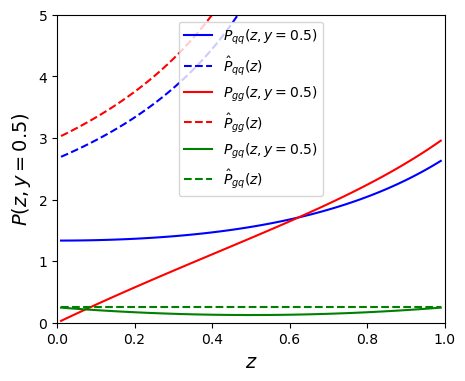

In [18]:
# Plot the different splitting kernel distributions with their overestimates
fig, ax = plt.subplots(figsize=(5, 4))
z = np.linspace(0.01, 0.99, 100)
ax.plot(z, puu.Value(z, 0.5), label=r"$P_{qq}(z, y=0.5)$", color='blue')
ax.plot(z, puu.Estimate(z), label=r"$\hat{P}_{qq}(z)$", color='blue', linestyle='--')
ax.plot(z, pgg.Value(z, 0.5), label=r"$P_{gg}(z, y=0.5)$", color='red')
ax.plot(z, pgg.Estimate(z), label=r"$\hat{P}_{gg}(z)$", color='red', linestyle='--')
ax.plot(z, pgu.Value(z, 0.5), label=r"$P_{gq}(z, y=0.5)$", color='green')
ax.plot(z, pgu.Estimate(z) * np.ones(len(z)), label=r"$\hat{P}_{gq}(z)$", color='green', linestyle='--')
ax.set_xlabel(r"$z$", fontsize = 14)
ax.set_ylabel(r"$P(z, y=0.5)$", fontsize = 14)
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)

This allows us to sample from a simplified Sudakov form factor:
$$
\Delta_{\text{trial}}(t_{\text{max}}, t) = \exp\left(-g \cdot \log\left(\frac{t_{\text{max}}}{t}\right)\right)
$$
where the quantity $g$ is the **effective emission rate** under the trial kernel:

```python
g = self.alphaMax / (2. * np.pi) * kernel.Integral(1. - zp, zp)
```
In this code snippet:

* `alphaMax` is a conservative overestimate of the running coupling.
* `kernel.Integral(...)` computes the integrated splitting function over allowed values of $z$.
* So `g` is the total trial branching rate (i.e. the exponent in the trial Sudakov).

This yields a form:
$$
\Delta_{\text{trial}}(t_{\text{max}}, t) = \left(\frac{t}{t_{\text{max}}}\right)^g
$$
We **invert** this to sample a trial emission scale $t$ via:
```python
tt = self.t * np.power(np.random.random(), 1. / g)
```
This draws $t$ from the correct no-emission probability under the trial Sudakov. For instance, if `g = 1`, then we’re sampling uniformly in $\log t$; if `g` is large, we preferentially draw soft/collinear emissions at low $t$, as expected from QCD.

### The veto step: correcting to physical Sudakov

Once a trial scale is chosen, the algorithm will then sample internal emission variables (like $z$, $y$), and evaluate the true splitting probability:
```python
f = (1. - y) * self.alpha(t) * s[2].Value(z, y)
```
* `f` is the physical differential rate: full kernel × running coupling.
* `g` is the overestimated rate used for generating the scale.

The veto algorithm corrects the distribution:
```python
if f / g > np.random.random():
```
This ensures that, statistically, emissions follow the true differential distribution $\mathrm{d}\Phi \, \boldsymbol{V}_{ij,k}$, but their timing (i.e. the emission scale) is still governed by the exponential **Sudakov suppression**.

### Exercise
Using the `Kernel` classes above, write an accept-reject algorithm that allows you to visualize the Sudakov form factor distributions.

In [ ]:
# Loop over each kernel, perform the accept reject


### Solution

/home/tony/Code/RESEARCH/inprog/MCGen/tutorials/mc/alphas.py:61: RuntimeWarning: invalid value encountered in log
  return asref / w * (1. - b1 / b0 * asref * np.log(w) / w)
/home/tony/Code/RESEARCH/inprog/MCGen/tutorials/mc/alphas.py:60: RuntimeWarning: divide by zero encountered in log
  w = 1. + b0 * asref * np.log(t / tref)


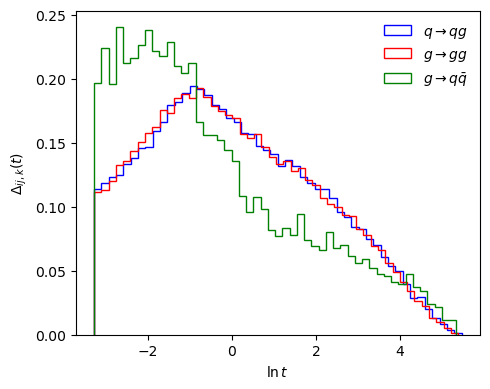

In [19]:
# Generate and plot Sudakov distributions for each splitting kernel using accept-reject
n_samples = 100000
tmax = 1000.0
tmin = 1.0

kernels = [puu, pgg, pgu]
labels = [r"$q \to qg$", r"$g \to gg$", r"$g \to q\bar{q}$"]
colors = ['blue', 'red', 'green']

fig, ax = plt.subplots(figsize=(5, 4))
for kernel, label, color in zip(kernels, labels, colors):
    sudakov = []
    for _ in range(n_samples):
        t = tmax
        while t > tmin:
            zp = 0.8
            zm = 0.2
            # Compute the effective emission rate
            g = alphas(tmin) / (2. * np.pi) * kernel.Integral(zm, zp)
            # Compute the trail emission scale
            tt = t * np.power(np.random.random(), 1. / g)
            # Generate z and y values from true distribution
            z = kernel.GenerateZ(zm, zp)
            y = tt / tmax / z / (1. - z)
            # Accept reject (if kinematics are valid)
            if y < 1.:
                f = (1. - y) * alphas(tt) * kernel.Value(z, y)
                g_trial = alphas(tmin) * kernel.Estimate(z)
                if f / g_trial > np.random.random():
                    t = tt
                    sudakov.append(t)
                    break
            t = tt
    ax.hist(np.log(sudakov), bins=50, density=True, histtype='step', label=label, color=color)
    #ax.hist(sudakov, bins=50, density=True, histtype='step', label=label, color=color)
#ax.set_xscale('log')
#ax.set_xlabel(r"$t$")
ax.set_xlabel(r"$\ln t$")
ax.set_ylabel(r"$\Delta_{ij,k}(t)$")
ax.legend(frameon = False)
fig.tight_layout()


### Putting it all together
1. The code will sample a scale from a trial Sudakov, using an overestimated emission rate `g`, for **all possible splittings**: every color-connected emitter–spectator pair and allowed splitting kernel proposes a candidate emission.
3. The emission with the **largest scale** (i.e., the hardest and earliest in the shower evolution) is selected. This corresponds to the most probable *first* emission across the entire event. This ***"winner-takes-all"*** selection statistically reproduces the correct total no-emission probability as the product of all individual Sudakov's.
4. Once the winning configuration is identified, the true QCD emission probability `f` is computed, and the emission is accepted with probability $f / g$, correcting the trial distribution via the veto algorithm.
5. This procedure yields both:

   * the correct differential emission rate (via $\boldsymbol{V}_{ij,k}$), and
   * the correct no-emission probability (via $\Delta_{ij,k}$).
   
Now that we have a handle on the algorithmic prescription, let's code it up.


In [24]:
class Shower:
    def __init__(self, alpha, t0, pdb):
        """
        Final state parton shower for, e.g., e+ e- -> q qbar.

        Parameters:
        - alpha: callable function for the running coupling constant \alpha_s(t)
        - t0: cutoff scale for the shower evolution
        - pdb: Particle database instance containing particle information
        """
        self.t0 = t0
        self.alpha = alpha
        self.alphaMax = alpha(self.t0)
        # Define the allowed flavors for each kernel
        Pqq_flavors = [pdb[f'{flav}'].pid for flav in ['u', 'ubar', 'd', 'dbar', 's', 'sbar', 'c', 'cbar', 'b', 'bbar']]
        Pgq_flavors = [pdb[f'{flav}'].pid for flav in ['u', 'd', 's', 'c', 'b']]
        # Initialize the kernels
        self.kernels = [Pqq([flav,flav,21]) for flav in Pqq_flavors]
        self.kernels += [Pgq([21,flav,-flav]) for flav in Pgq_flavors]
        self.kernels += [Pgg([21,21,21])]
        self.pdb = pdb

    def generate_kinematics(self, z, y, phi, pijt, pkt):
        """
        Generate kinematics of radiated partons.

        z: momentum fraction of the emitted parton
        y: momentum fraction of the recoiling parton
        phi: azimuthal angle of the emission
        pijt: momentum of the incoming parton i and j (before emission)
        pkt: momentum of the recoiling parton k (before emission)
        """
        # Total momentum of the dipole system
        Q = pijt + pkt
        M2_Q = Q[0]**2 - Q[1]**2 - Q[2]**2 - Q[3]**2  # Invariant mass squared
        # Magnitude of transverse momentum for the emission (~Q * Q is just the invariant mass squared)
        rkt = np.sqrt(M2_Q * y * z * (1. - z))

        # Construct a transverse vector orthogonal to the dipole axis
        kt1 = pijt.cross(pkt)
        # If the cross product is numerically zero, pick a fixed direction
        if np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2) < 1.e-6:
            kt1 = pijt.cross(FourVector(0., 1., 0., 0.))
        
        # Normalize and scale kt1 by rkt and azimuthal angle phi
        P_kt1 = np.sqrt(kt1[0]**2 + kt1[1]**2 + kt1[2]**2 + kt1[3]**2)
        kt1 *= rkt * np.cos(phi) / P_kt1
        
        # Construct a second transverse vector in the dipole rest frame
        kt2cms = Q.boost(pijt).cross(kt1)
        P_kt2cms = np.sqrt(kt2cms[0]**2 + kt2cms[1]**2 + kt2cms[2]**2 + kt2cms[3]**2)
        kt2cms *= rkt * np.sin(phi) / P_kt2cms

        # Boost back to the lab frame
        kt2 = Q.boost_back(kt2cms)

        # Assign momenta to the emitted partons and recoiling spectator
        pi = z * pijt + (1. - z) * y * pkt + kt1 + kt2
        pj = (1. - z) * pijt + z * y * pkt - kt1 - kt2
        pk = (1. - y) * pkt

        # Return the new momenta after the branching
        return [FourVector(*pi), FourVector(*pj), FourVector(*pk)]

    def assign_colors(self, flavs, colij, colk):
        """
        Assign color charge.
        
        flavs: List of particle flavors [emitter, spectator, emitted].
        colij: List of color lines for the emitter and spectator [color, anticolor].
        colk: List of color lines for the spectator [color, anticolor].

        Returns list of color assignments for the emitted parton and the emitter.
        """
        # Increment color index for each new emission
        self.c += 1

        # If the emitter is not a gluon (i.e., it's a quark or antiquark)
        if flavs[0] != 21:
            # For quarks (positive pid), assign new color line to the quark end
            if flavs[0] > 0:
                # [new color, 0] for emitted gluon, [original color, new color] for emitter
                return [[self.c, 0], [colij[0], self.c]]
            else:
                # For antiquarks (negative pid), assign new color line to the antiquark end
                # [0, new color] for emitted gluon, [new color, original anticolor] for emitter
                return [[0, self.c], [self.c, colij[1]]]
        else:
            # If the emitter is a gluon
            if flavs[1] == 21:
            # Gluon splits into two gluons
                # If color lines match, randomly assign color flow to preserve symmetry
                if colij[0] == colk[1]:
                    if colij[1] == colk[0] and np.random.random() > 0.5:
                        # Assign new color between the two gluons
                        return [[colij[0], self.c], [self.c, colij[1]]]
                        # Alternate color assignment
                    return [[self.c, colij[1]], [colij[0], self.c]]
                else:
                    # Default color assignment for gluon splitting
                    return [[colij[0], self.c], [self.c, colij[1]]]
            else:
                # Gluon splits into quark-antiquark pair
                if flavs[1] > 0:
                    # Quark: [original color, 0], Antiquark: [0, original anticolor]
                    return [[colij[0], 0], [0, colij[1]]]
                else:
                    # Antiquark: [0, original anticolor], Quark: [original color, 0]
                    return [[0, colij[1]], [colij[0], 0]]
                
    def check_color_connect(self, p1, p2):
        """
        Check if two particles are color-connected.

        p1, p2: Particle objects to check for color connection.
        """
        return (p1.c[0] > 0 and p1.c[0] == p2.c[1]) or \
               (p1.c[1] > 0 and p1.c[1] == p2.c[0])
    
    def generate_emission(self, event):
        """
        Generate a single emission in the parton shower evolution.

        Returns None if no emission is accepted, otherwise modifies the event in place.
        """
        # Continue evolving the shower until the evolution variable t drops below the cutoff t0
        while self.t > self.t0:
            t = self.t0  # Initialize the next emission scale to the cutoff
            # Loop over all possible emitter (split) and spectator (spect) pairs in the event
            for split in event[2:]:
                for spect in event[2:]:
                    # Skip if emitter and spectator are the same
                    if spect == split: continue
                    # Only consider color-connected pairs
                    if not self.check_color_connect(split, spect): continue
                    # Loop over all possible splitting kernels for this emitter flavor
                    for kernel in self.kernels:
                        # Only consider kernels matching the emitter's flavor
                        if kernel.flavs[0] != split.data.pid: continue 
                        # Invariant mass squared of the dipole
                        m2 = (split.p[0] + spect.p[0])**2 - (split.p[1] + spect.p[1])**2 \
                             - (split.p[2] + spect.p[2])**2 - (split.p[3] + spect.p[3])**2
                        # Skip if dipole mass is too small for further splitting
                        if m2 < 4. * self.t0: continue  
                        # Maximum allowed z for this kinematics
                        zp = .5 * (1. + np.sqrt(1. - 4. * self.t0 / m2))
                        # Overestimate of the splitting probability (for veto algorithm)
                        g = self.alphaMax / (2. * np.pi) * kernel.Integral(1. - zp, zp)
                        # Generate a trial emission scale tt using the Sudakov form factor
                        tt = self.t * np.power(np.random.random(), 1. / g)
                        # Keep the largest tt (i.e., the hardest emission)
                        if tt > t:
                            t = tt
                            # Store the best candidate emission
                            s = [split, spect, kernel, m2, zp]
                            
            # Update the evolution variable to the scale of the next emission
            self.t = t  
            if t > self.t0:
                # Generate the splitting variable z for the chosen kernel and kinematics
                z = s[2].GenerateZ(1. - s[4], s[4])
                # Compute y from the emission scale and kinematics
                y = t / s[3] / z / (1. - z)
                if y < 1.:
                    # Compute the true splitting probability for this configuration
                    f = (1. - y) * self.alpha(t) * s[2].Value(z, y)
                    # Compute the overestimate used for the veto step
                    g = self.alphaMax * s[2].Estimate(z)
                    # Accept or reject the emission using the veto algorithm
                    if f / g > np.random.random():
                        # Generate a random azimuthal angle for the emission
                        phi = 2. * np.pi * np.random.random()
                        # Generate the new momenta after the emission
                        moms = self.generate_kinematics(z, y, phi, s[0].p, s[1].p)
                        # Assign new color connections after the emission
                        cols = self.assign_colors(s[2].flavs, s[0].c, s[1].c)
                        # Add the emitted particle to the event record
                        event.append(Particle(self.pdb[s[2].flavs[2]], moms[1], cols[1]))
                        # Update the emitter's flavor, momentum, and color
                        s[0].data = self.pdb[s[2].flavs[1]] #.id = s[2].flavs[1]  # Update emitter's flavor
                        s[0].p = moms[0]  # Update emitter's momentum
                        s[0].c = cols[0]  # Update emitter's color
                        # Update the spectator's momentum
                        s[1].p = moms[2]
                        return  # End after one emission (for Markovian evolution)
                    
    def cascade(self, event, t):
        """
        Recursively iterate the parton shower for a given event until the 
        evolution variable t drops below the cutoff t0.
        """
        # Initialize the evolution variable and color index.
        self.t = t
        self.c = 1

        # Continue evolving the shower until the evolution variable t drops below the cutoff t0
        while self.t > self.t0:
            self.generate_emission(event)

In [25]:
# For sanity checks we can define the following function
def check_event(event):
    psum = FourVector(0,0,0,0)
    csum = {}
    i = 0
    for particle in event:
        if i == 0 or i == 1:
            particle.p[0] = -particle.p[0]
            i+=1
        psum += particle.p
        if particle.c[0] > 0: 
            csum[particle.c[0]] = csum.get(particle.c[0],0) + 1
            if csum[particle.c[0]] == 0: del csum[particle.c[0]]
        if particle.c[1] > 0:
            csum[particle.c[1]] = csum.get(particle.c[1],0) - 1
            if csum[particle.c[1]] == 0: del csum[particle.c[1]]
        
    return (np.fabs(psum[0])<1.e-8 and \
            np.fabs(psum[1])<1.e-8 and \
            np.fabs(psum[2])<1.e-8 and \
            np.fabs(psum[3])<1.e-8 and \
            len(csum) == 0)

## Showering a $q\bar{q}$ ($jj$) final state
The only thing that we need now is a final partonic state to serve as the starting point for the shower. This would be the output of a hard matrix element calculation. For convenience, we'll do this using a library (see `eetojj.py` for more details).

In [26]:
# Intialize the eeTojj generator
hardxs = eeTojj(alphas, pdb)
# Initialize the parton shower
shower = Shower(alphas, t0 = 1.0, pdb = pdb)

# Generate events
nevents = 1

for i in range(nevents):
    event, weight = hardxs.generate_LO_event()
    for particle in event:
        print(particle.data.name, particle.data.pid)
        print("pmu:", particle.p)
    print('Weight', weight, '\n')
    # Compute the hard scale
    t = (event[0].p[0] + event[1].p[0])**2 - (event[0].p[1] + event[1].p[1])**2 - (event[0].p[2] + event[1].p[2])**2 - (event[0].p[3] + event[1].p[3])**2
    shower.cascade(event, t)
    # Check the event for conservation of momentum and color
    assert check_event(event), "Event violates energy-momentum and/color conservation."
    
# Print out the particles after shower evolution
for particle in event:
    print(particle.data.name, particle.data.pid)
    print("pmu:", particle.p)
    print("color:", particle.c)

e+ -11
pmu: 45.60000000286317 0 0 -45.6
e- 11
pmu: 45.60000000286317 0 0 45.6
c 4
pmu: 45.6 26.536473393676424 -35.17274024771078 11.749635028109168
cbar -4
pmu: 45.6 -26.536473393676424 35.17274024771078 -11.749635028109168
Weight 31225.425325530487 

e+ -11
pmu: -45.60000000286317 0 0 -45.6
color: [0, 0]
e- 11
pmu: -45.60000000286317 0 0 45.6
color: [0, 0]
c 4
pmu: 13.07144016146031 5.752518574155731 -11.663820146962541 1.3139168649277657
color: [3, 0]
cbar -4
pmu: 43.07893419058196 -25.06936383719991 33.22816145687645 -11.100038467966481
color: [0, 1]
g 21
pmu: 6.856990399628578 4.33853180423961 -2.4842819704309496 4.692952398607043
color: [4, 2]
g 21
pmu: 23.594954130497786 14.683640235232632 -18.183903282072805 3.233918875107089
color: [5, 3]
g 21
pmu: 2.1817076053474076 -0.28173831415377326 1.4374898911095932 1.6168161338031728
color: [1, 4]
g 21
pmu: 2.415973512483954 0.5764115377257082 -2.333645948519748 0.24243419552141
color: [2, 5]


In [23]:
# Let's generate a bunch of events
nevents = 10000
events = []
for i in range(nevents):
    event, weight = hardxs.generate_LO_event()
    # Compute the hard scale
    t = (event[0].p[0] + event[1].p[0])**2 - (event[0].p[1] + event[1].p[1])**2 - (event[0].p[2] + event[1].p[2])**2 - (event[0].p[3] + event[1].p[3])**2
    shower.cascade(event, t)
    assert check_event(event), "Event violates energy-momentum and/color conservation."
    events.append(event)  # Store the evolved event

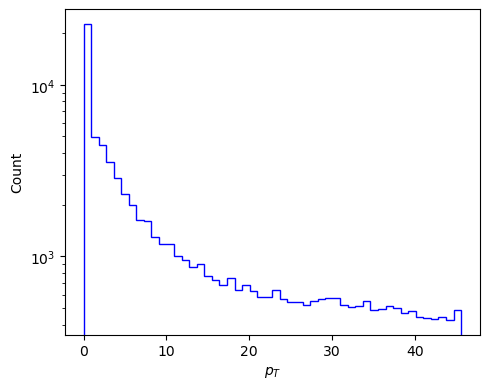

In [27]:
# Let's take a look at the global pT spectrum
fig, ax = plt.subplots(figsize=(5, 4))
pt_spectrum = []
for event in events:
    # Calculate the total transverse momentum of the event
    for particle in event:
        pt_spectrum.append(np.sqrt(particle.p[1]**2 + particle.p[2]**2))
ax.hist(pt_spectrum, bins=50, histtype='step', label='pT spectrum', color='blue')
ax.set_xlabel(r"$p_T$")
ax.set_ylabel("Count")
ax.set_yscale('log')
fig.tight_layout()

Event record:
------------------------
name: e+ id: -11
pmu: -45.60000000286317 0 0 -45.6 color: [0, 0]
name: e- id: 11
pmu: -45.60000000286317 0 0 45.6 color: [0, 0]
name: d id: 1
pmu: 42.75367730445226 17.286941932463876 39.08931444327581 -1.0315318858706137 color: [2, 0]
name: dbar id: -1
pmu: 44.725933113775554 -17.313765709181876 -41.188357804198915 -2.0400468766106976 color: [0, 1]
name: g id: 21
pmu: 3.7203895817721824 0.026823776718003844 2.099043360923102 3.0715787624813116 color: [1, 2]


/home/tony/miniconda3/envs/homers_magic/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


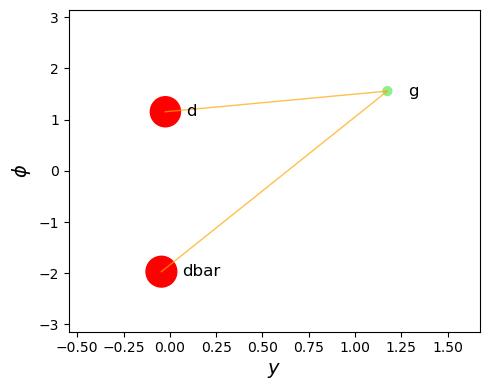

In [28]:
event, weight = hardxs.generate_LO_event()
# Compute the hard scale
t = (event[0].p[0] + event[1].p[0])**2 - (event[0].p[1] + event[1].p[1])**2 - (event[0].p[2] + event[1].p[2])**2 - (event[0].p[3] + event[1].p[3])**2
shower.cascade(event, t)
# Check the event for conservation of momentum and color
assert check_event(event), "Event violates energy-momentum and/color conservation."

rapidities = []
phis = []
energies = []

for particle in event:
    p = particle.p
    E, px, py, pz = p[0], p[1], p[2], p[3]
    # Safe rapidity calculation
    if (E + pz) > 0 and (E - pz) > 0:
        y = 0.5 * np.log((E + pz) / (E - pz))
    else:
        y = np.nan
    phi = np.arctan2(py, px)
    rapidities.append(y)
    phis.append(phi)
    energies.append(E)

# Assign colors based on particle type
marker_colors = []
for particle in event:
    pid = particle.data.pid
    if abs(pid) in [1, 2, 3, 4, 5]:  # quarks (d, u, s, c, b)
        marker_colors.append('red')
    elif pid == 21:  # gluon
        marker_colors.append('lightgreen')
    else:
        marker_colors.append('gray')

energies = np.array(energies)
sizes = 100 * (energies / np.nanmax(np.abs(energies))) * 5

fig, ax = plt.subplots(figsize=(5, 4))
sc = ax.scatter(rapidities, phis, s=sizes, c=marker_colors, alpha=1.0)

# Draw lines for color connections
# Draw lines for color connections (behind markers)
for i, pi in enumerate(event):
    for j, pj in enumerate(event):
        if i >= j:
            continue  # Avoid double-drawing and self-connections
        # Check if pi's color matches pj's anticolor or vice versa
        if (pi.c[0] > 0 and pi.c[0] == pj.c[1]) or (pj.c[0] > 0 and pj.c[0] == pi.c[1]):
            ax.plot([rapidities[i], rapidities[j]], [phis[i], phis[j]], color='orange', lw=1, alpha=0.7, zorder=1)



ax.set_xlabel(r'$y$', fontsize=14)
ax.set_ylabel(r'$\phi$', fontsize=14)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlim(np.nanmin(rapidities)-0.5, np.nanmax(rapidities)+0.5)

# Label the two hardest partons (excluding electron and positron)
n_label = len(event) - 2
# Find indices of non-lepton partons
non_lepton_indices = [i for i, particle in enumerate(event) if abs(particle.data.pid) not in [11, -11]]
if len(non_lepton_indices) > 0:
    # Get energies of non-lepton partons
    non_lepton_energies = np.abs(energies[non_lepton_indices])
    # Indices (in non_lepton_indices) of the two hardest partons
    idx_hardest_local = np.argsort(non_lepton_energies)[-n_label:]
    # Map back to indices in the full event list
    idx_hardest = [non_lepton_indices[i] for i in idx_hardest_local]
    for idx in idx_hardest:
        label = event[idx].data.name
        ax.annotate(label, (rapidities[idx], phis[idx]),
                    xytext=(15, 0), textcoords='offset points',
                    ha='left', va='center', fontsize=12, color='black'
                    )

plt.tight_layout()

# Print out the particles after shower evolution
print("Event record:\n------------------------")
for particle in event:
    print('name:', particle.data.name, 'id:', particle.data.pid)
    print("pmu:", particle.p, 'color:', particle.c)


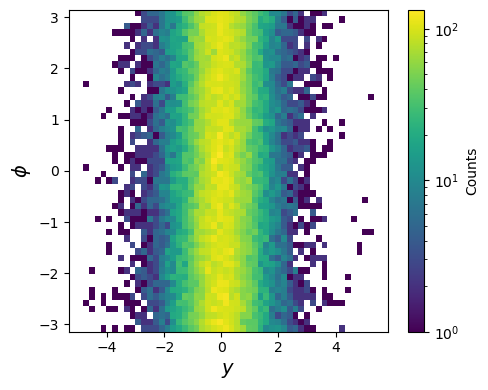

In [29]:
# Collect all rapidity and phi values from all events (excluding leptons)
all_rapidities = []
all_phis = []

for event in events:
    for particle in event:
        pid = particle.data.pid
        # Exclude leptons (e+/e-)
        if abs(pid) in [11, -11]:
            continue
        p = particle.p
        E, px, py, pz = p[0], p[1], p[2], p[3]
        # Safe rapidity calculation
        if (E + pz) > 0 and (E - pz) > 0:
            y = 0.5 * np.log((E + pz) / (E - pz))
        else:
            y = np.nan
        phi = np.arctan2(py, px)
        all_rapidities.append(y)
        all_phis.append(phi)

all_rapidities = np.array(all_rapidities)
all_phis = np.array(all_phis)

# Remove NaN rapidities for plotting
mask = ~np.isnan(all_rapidities)
all_rapidities = all_rapidities[mask]
all_phis = all_phis[mask]

# 2D histogram
fig, ax = plt.subplots(figsize=(5, 4))
h = ax.hist2d(all_rapidities, all_phis, bins=[50, 50], range=[[np.min(all_rapidities), np.max(all_rapidities)], [-np.pi, np.pi]], cmap='viridis', norm='log')
ax.set_xlabel(r'$y$', fontsize = 14)
ax.set_ylabel(r'$\phi$', fontsize = 14)
ax.set_ylim(-np.pi, np.pi)
ax.set_xlim(np.min(all_rapidities)-0.5, np.max(all_rapidities)+0.5)
fig.colorbar(h[3], ax=ax, label='Counts')
plt.tight_layout()

# **References**
- S. Hoeche's parton shower tutorial [GitLab: shoeche/tutorials/ps](https://gitlab.com/shoeche/tutorials/-/tree/master/ps?ref_type=heads)
- Introduction to parton-shower event generators by S. Hoeche - [arXiv:1411.4085](https://arxiv.org/abs/1411.4085)
- A General Algorithm for Calculating Jet Cross Sections in NLO QCD by S. Catani and M.H. Seymour - [arXiv:9605323](https://arxiv.org/abs/hep-ph/9605323)
- PYTHIA 6.4 Physics and Manual [https://arxiv.org/abs/hep-ph/0603175](https://arxiv.org/abs/hep-ph/0603175)